In [401]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.signal import convolve2d
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans

#RCARRY

In [402]:
def RCARRY(x,s,r,c,B):
  y=(x[s-1]-x[r-1]-c)
  if y<0:
    c=1
  else:
    c=0
  return y%B

def get_RCARRY(r,s,n,B):
  x_n0=np.zeros(n,dtype='int')
  x_n1=np.zeros(n,dtype='int')
  a=np.random.randint(1,B,r,dtype='int')
  c=0

  for i in range(n-1):
    new_rand=RCARRY(a,s,r,c,B)
    x_n1[i]=new_rand
    x_n0[i+1]=new_rand
    a=np.append([new_rand],a[:-1])

  x_n1[-1]=RCARRY(a,s,r,c,B)
  return x_n1/B

#Diaphony

In [403]:
def calc_T_G(xs,plot=False):
  n=len(xs)

  s=0.5
  T_guilliver=0
  for j in range(n):
    for k in range(j):
      T_guilliver+=beta_gulliver(xs[j]-xs[k])
  T_guilliver=(T_guilliver*2+n)/n
  if plot:
    plt.scatter(xs[:,0],xs[:,1])
    plt.title('n={0}, T_G={1}'.format(n,T_guilliver))
    plt.show()
  else:
    return T_guilliver

def beta_gulliver(x,s=0.5):
  dims=2
  pre_term=1/(((1+s)/(1-s))**dims - 1)
  term=np.zeros(dims)
  for i in range(dims):
    term[i]=(1-s**2)/(1-2*s*np.cos(2*np.pi*x[i])+s**2)
  product=np.product(term)
  return pre_term*(-1+product)

In [404]:
n_points=100
dims=2
xs=np.reshape(get_RCARRY(1545,512,2*n_points,2**24),(n_points,2))
T_guilliver=0
for j in range(n_points):
  for k in range(n_points):
    T_guilliver+=beta_gulliver(xs[j]-xs[k])
T_guilliver=T_guilliver/n_points
print(T_guilliver)

print(calc_T_G(xs))
print('check if diaphony calculation is working: results are equal and close to 1')

0.5107847219467396
0.5107847219467391
check if diaphony calculation is working: results are equal and close to 1


#make img

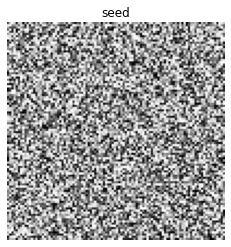

In [405]:
n=100
dims=2
seed=np.reshape(get_RCARRY(1545,512,n**dims,2**24),(*[n]*dims,))
plt.imshow(seed,cmap='Greys')
plt.title('seed')
plt.axis('off')
plt.show()

In [406]:
hpf_size=9
high_pass_filter=np.zeros((hpf_size,hpf_size))
for i in range(hpf_size):
  for j in range(hpf_size):
    distance =  np.sqrt((i-hpf_size//2)**2 + (j-hpf_size//2)**2)
    if distance !=0:
      high_pass_filter[i,j] = -1/distance
high_pass_filter[hpf_size//2,hpf_size//2] = -np.sum(high_pass_filter)

In [407]:
gb_size=9
t=np.linspace(-1,1,gb_size)
bump=np.exp(-1*t**2)
gaus_kernel=bump[:,np.newaxis]*bump[np.newaxis,:]
gaus_kernel/=np.sum(gaus_kernel)

In [408]:
def apply_kernel(kernel,img):
  return convolve2d(img,kernel, boundary='wrap', mode='same')

In [409]:
def turing(img):
  img=apply_kernel(high_pass_filter,img)
  img=(img > threshold).astype('int')
  img=apply_kernel(gaus_kernel,img)
  return img

In [410]:
threshold=0.5

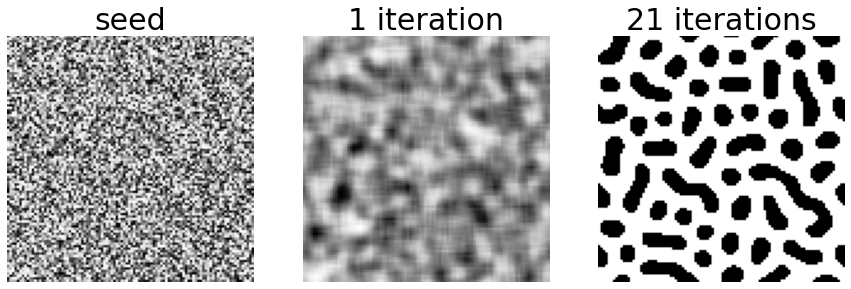

In [411]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True,figsize=(15,5))
img=seed.copy()
ax1.imshow(img,cmap='Greys')
ax1.axis('off')
ax1.title.set_text('seed')
ax1.title.set_fontsize(30)
img=turing(img)
ax2.imshow(img,cmap='Greys')
ax2.axis('off')
ax2.title.set_text('1 iteration')
ax2.title.set_fontsize(30)
difference=1
turing_iterations=0
while turing_iterations < 50:
  result=turing(img)
  if np.sum(result-img)==0:
    break
  turing_iterations+=1
  img=result
img=apply_kernel(high_pass_filter,img)
img=(img > threshold).astype('int')
ax3.imshow(img,cmap='Greys')
ax3.title.set_fontsize(30)
ax3.axis('off')
ax3.title.set_text('{0} iterations'.format(turing_iterations))
f.show()

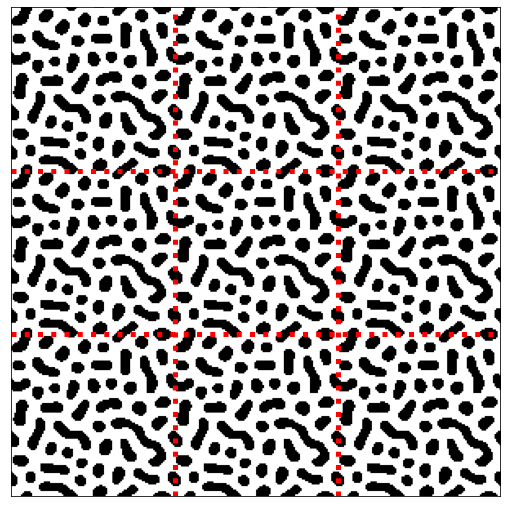

In [412]:
plt.figure(figsize=(9,9))
plt.imshow(np.tile(img,(3,3)),cmap='Greys')
plt.axvline(n,color='red',linestyle=':',linewidth=5)
plt.axvline(2*n,color='red',linestyle=':',linewidth=5)
plt.axhline(n,color='red',linestyle=':',linewidth=5)
plt.axhline(2*n,color='red',linestyle=':',linewidth=5)
plt.xticks([])  
plt.yticks([])  
plt.show()

In [413]:
def plot_dataset(background,points,title):
    plt.figure(figsize=(10,10))
    plt.imshow(background,cmap='Greys',alpha=0.2)
    plt.imshow(np.ma.masked_array(data=points,mask=1-points),cmap='autumn',interpolation='Nearest')
    plt.title(title,fontsize=50)
    plt.xticks([])  
    plt.yticks([])  
    plt.show()

#k means cluster

In [414]:
def kmeans_centering(img,n_clusters,plot=True):
  blob_coords=[]
  for i in range(n):
    for j in range(n):
      if img[i,j]==1:
        blob_coords.append([i,j])

  kmeans = KMeans(init="random", n_clusters=n_clusters, n_init=10, max_iter=100, random_state=42,verbose=0)
  kmeans.fit(blob_coords)
  kcenters=kmeans.cluster_centers_

  kcenters[0].astype('int')
  if plot==True:
    centroids=np.zeros((n,n))
    for center in kcenters:
      centroids[center[0].astype('int'),center[1].astype('int')]=1 
    plot_dataset(img,centroids,'kmeans')

  return kcenters/n  

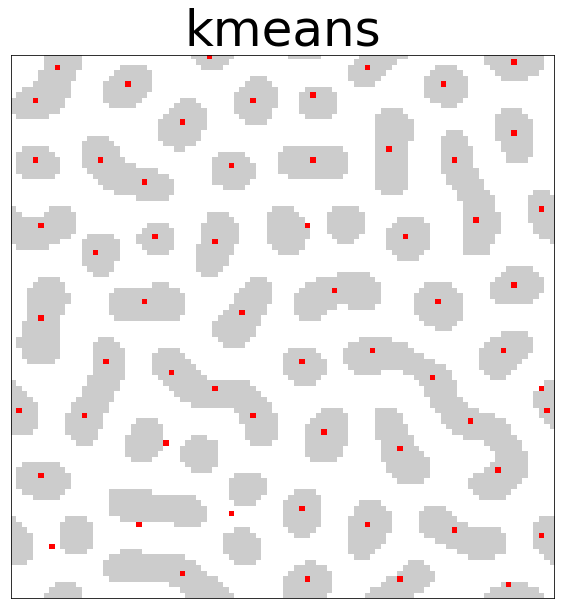

In [415]:
centers_kmean=kmeans_centering(img=img, n_clusters=n**2//(2*hpf_size*gb_size), plot=True)

#centroid

In [416]:
def blob_centering(img,plot=True):
  cv2img=img.astype('uint8')-1
  params = cv2.SimpleBlobDetector_Params()

  params.filterByCircularity = False
  params.filterByConvexity = False
  params.filterByInertia = False
  params.filterByColor=False
  #params.filterByArea=False
  params.minThreshold = 10;
  params.maxThreshold = 200;
  params.thresholdStep=2
  detector=cv2.SimpleBlobDetector_create(params)

  cv2img_bordered=cv2.copyMakeBorder(cv2img,1,1,1,1,cv2.BORDER_CONSTANT,value=255)
  keypoints=detector.detect(cv2img_bordered)

  centers_centroid=np.array([keypoint.pt[::-1] for keypoint in keypoints])

  if plot:
    centroids=np.zeros((n,n))
    for center in centers_centroid:
      centroids[center[0].astype('int')-1,center[1].astype('int')-1]=1 
    plot_dataset(img,centroids,'blob detector')

  return (centers_centroid-1)/n  

def blob_blurred_centering(img,plot=True):

  blurred_img=apply_kernel(gaus_kernel,img)
  cv2img=img.astype('uint8')-1
  cv2img=(255-blurred_img*255).astype('uint8')
  params = cv2.SimpleBlobDetector_Params()

  params.filterByCircularity = False
  params.filterByConvexity = False
  params.filterByInertia = False
  params.filterByColor = False
  #params.filterByArea = False

  params.minThreshold = 10;
  params.maxThreshold = 200;
  params.thresholdStep=2
  detector=cv2.SimpleBlobDetector_create(params)

  cv2img_bordered=cv2.copyMakeBorder(cv2img,1,1,1,1,cv2.BORDER_CONSTANT,value=255)
  keypoints=detector.detect(cv2img_bordered)

  centers_centroid_blurred=np.array([keypoint.pt[::-1] for keypoint in keypoints])

  if plot:
    centroids_blurred=np.zeros((n,n))
    for center in centers_centroid_blurred:
      centroids_blurred[center[0].astype('int')-1,center[1].astype('int')-1]=1 
    plot_dataset(img,centroids_blurred,'blurred blob detector')

  return (centers_centroid_blurred-1)/n  

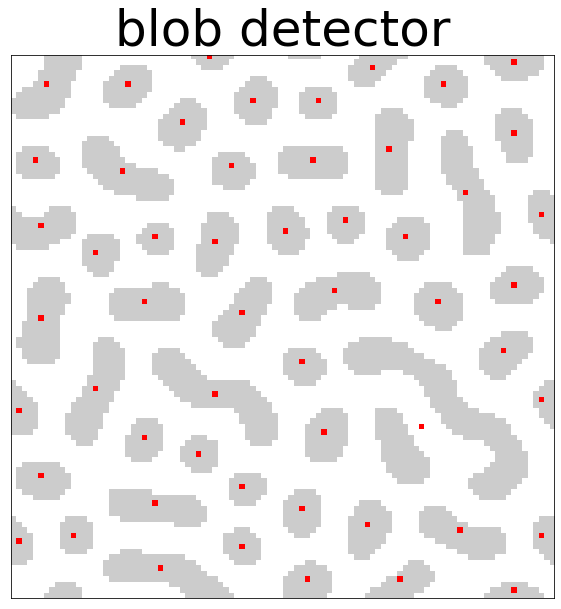

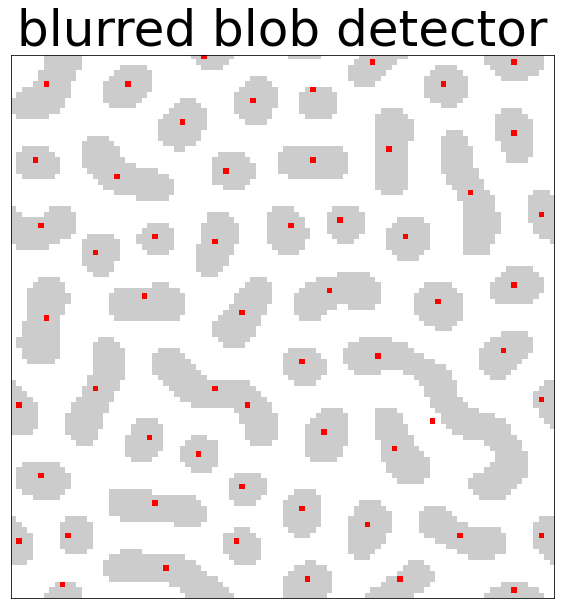

In [417]:
centers_blob=blob_centering(img=img, plot=True)
centers_blob_blurred=blob_blurred_centering(img=img, plot=True)

#shrink

In [418]:
def shrink_square(image):
  n,m=image.shape
  zero_kernel=np.zeros((3,3))
  single_kernel=np.zeros((5,5))
  single_kernel[2,2]=1
  shrunk=image.copy()
  for i in range(n):
    for j in range(m):
      if shrunk[i,j]==1:
        neighbours=image[[i-1,(i+1)%m,i,i],[j,j,(j+1)%n,(j+1)%n]]
        if (neighbours==0).any():
          if not (shrunk[[(i-2) % m, (i-1) % m, i, (i+1) % m, (i+2) % m]][:,[(j-2) % n, (j-1) % n, j, (j+1) % n, (j+2) % n]]==single_kernel).all():
            shrunk[i,j]=0
  return shrunk

def shrink_round(image):
  n,m=image.shape
  zero_kernel=np.zeros((3,3))
  single_kernel=np.zeros((5,5))
  single_kernel[2,2]=1
  shrunk=image.copy()
  for i in range(n):
    for j in range(m):
      if shrunk[i,j]==1:
        neighbours=image[[(i-1) % m, i, (i+1) % m]][:,[(j-1) % n, j, (j+1) % n]]
        if (neighbours==zero_kernel).any():
          if not (shrunk[[(i-2) % m, (i-1) % m, i, (i+1) % m, (i+2) % m]][:,[(j-2) % n, (j-1) % n, j, (j+1) % n, (j+2) % n]]==single_kernel).all():
            shrunk[i,j]=0
  return shrunk

In [419]:
def shrink_square_centering(img=img, plot=True):
  shrunken_square=shrink_square(img)
  for i in range(6):
    shrunken_square=shrink_square(shrunken_square)
  if plot:
    plot_dataset(img,shrunken_square,'shrinking square')

  centers_shrunken_square=[]
  for i in range(n):
    for j in range(n):
      if shrunken_square[i,j]==1:
        centers_shrunken_square.append([i,j])
  return np.array(centers_shrunken_square)/n  

def shrink_round_centering(img=img, plot=True):
  shrunken_round=shrink_round(img)
  for i in range(6):
    shrunken_round=shrink_round(shrunken_round)
  if plot:
    plot_dataset(img,shrunken_round,'shrinking round')

  centers_shrunken_round=[]
  for i in range(n):
    for j in range(n):
      if shrunken_round[i,j]==1:
        centers_shrunken_round.append([i,j])
  return np.array(centers_shrunken_round)/n  

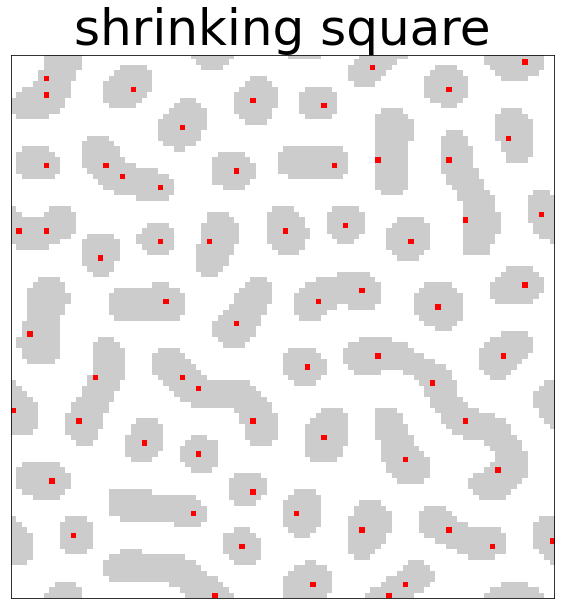

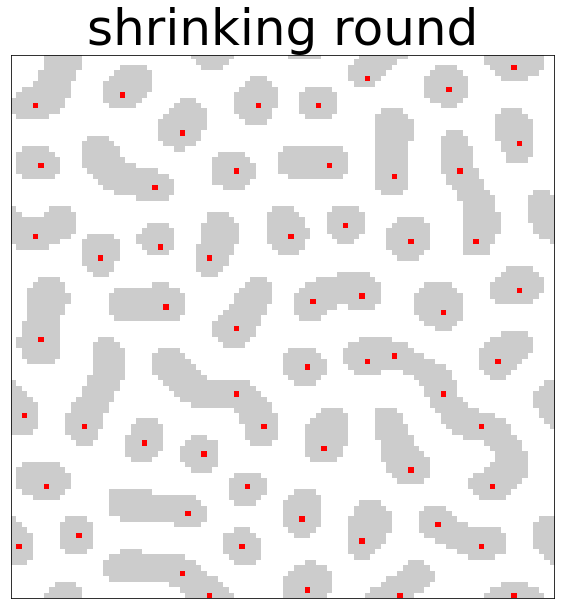

In [420]:
centers_shrink_square=shrink_square_centering(img)
centers_shrink_round=shrink_round_centering(img)

#Custom k means clustering

In [421]:
def find_valid_neighbours(i,j,img,checked):
  neighbours=[[i-1,j],[i+1,j],[i,j-1],[i,j+1]]
  neighbours=[coord for coord in neighbours if img[coord[0]%n,coord[1]%n] == 1 and checked[coord[0]%n,coord[1]%n] == 0]
  return neighbours

In [422]:
def custom_centering(img=img, plot=True):
  checked=np.zeros(img.shape)
  centers_custom=[]
  for i in range(n):
    for j in range(n):
      if checked[i,j]==0:
        if img[i,j]==1:
          blob=[]
          blob.append([i,j]) 
          checked[i,j]=1
          neighbours=find_valid_neighbours(i,j,img,checked)
          while len(neighbours) !=0:
            blob=np.concatenate((blob,neighbours))
            for neighbour in neighbours:
              checked[neighbour[0]%n,neighbour[1]%n]=1
            new_neighbours=[]
            for neighbour in neighbours:
              temp_neighbours=find_valid_neighbours(neighbour[0],neighbour[1],img,checked)
              if len(temp_neighbours) !=0:
                for temp_neighbour in temp_neighbours:
                  new_neighbours.append(temp_neighbour)
            neighbours=new_neighbours
            if len(neighbours)!=0:
              neighbours=np.unique(neighbours,axis=0)

          k=int(1+len(blob)//(1.*hpf_size**2))

          kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=100, random_state=42,verbose=0)
          kmeans.fit(blob)
          for center in kmeans.cluster_centers_:
            centers_custom.append(center%n)

  if plot:
    centroids=np.zeros((n,n))
    for center in centers_custom:
      centroids[center[0].astype('int')%n,center[1].astype('int')%n]=1 
    plot_dataset(img,centroids,'periodic custom')

  return np.array(centers_custom)/n      

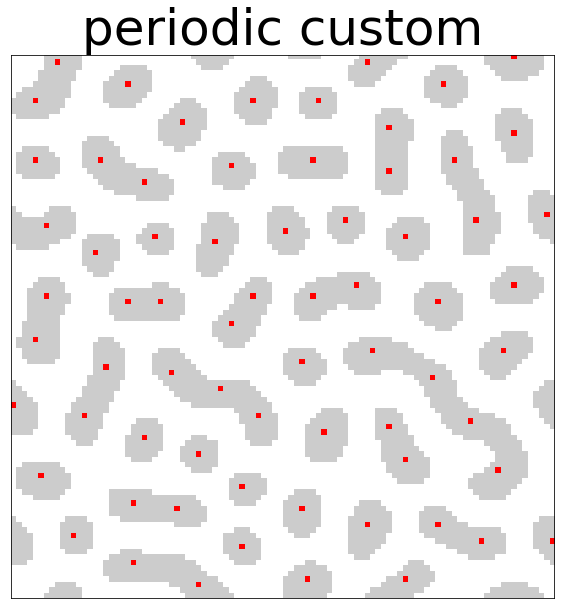

In [423]:
centers_custom=custom_centering(img,plot=True)

#evaluate methods

In [424]:
all_centers={'kmean':centers_kmean,'blob':centers_blob,'blob blurred':centers_blob_blurred,'shrink square':centers_shrink_square,'shrink round':centers_shrink_round,'custom':centers_custom}

In [425]:
centers_random=np.reshape(get_RCARRY(1545,512,len(all_centers['custom'])*dims,2**24),(len(all_centers['custom']),dims))
all_centers['random']=centers_random

centers_random=np.reshape(get_RCARRY(1545,512,73*dims,2**24),(73,dims))
all_centers['random']=centers_random

In [426]:
uniform=np.arange(0,100,10)
uniform_pointset=[]
for center in itertools.product(uniform, uniform):
  uniform_pointset.append(center)
all_centers['uniform']=(np.array(uniform_pointset)+5)/100

In [427]:
for method in all_centers:
  diaphony=calc_T_G(all_centers[method])
  print('diaphony of {0:.3f} for {1} point with method {2}'.format(diaphony,len(all_centers[method]),method))

diaphony of 0.210 for 61 point with method kmean
diaphony of 0.287 for 54 point with method blob
diaphony of 0.238 for 58 point with method blob blurred
diaphony of 0.212 for 65 point with method shrink square
diaphony of 0.247 for 60 point with method shrink round
diaphony of 0.097 for 69 point with method custom
diaphony of 0.999 for 73 point with method random
diaphony of 0.049 for 100 point with method uniform


#Quasi monte carlo

In [428]:
def squared(points):
  return np.abs(np.sum(points**2)/len(points)-(2/3))

print('evaluating x^2+y^2:')
for method in all_centers:
  print('error of {0:.5f} with method {1}'.format(squared(all_centers[method]),method))


evaluating x^2+y^2:
error of 0.00444 with method kmean
error of 0.01580 with method blob
error of 0.00286 with method blob blurred
error of 0.02504 with method shrink square
error of 0.02229 with method shrink round
error of 0.02992 with method custom
error of 0.03833 with method random
error of 0.00167 with method uniform


In [429]:
def waves(points):
  return np.abs(np.sum(points[:,1]*np.sin(20.5*np.pi*points[:,0])))/len(points)

print('evaluating sin(20.5pi*(x))*y:')
for method in all_centers:
  print('error of {0:.5f} with method {1}'.format(waves(all_centers[method]),method))


evaluating sin(20.5pi*(x))*y:
error of 0.03421 with method kmean
error of 0.01603 with method blob
error of 0.00759 with method blob blurred
error of 0.01694 with method shrink square
error of 0.03132 with method shrink round
error of 0.01726 with method custom
error of 0.07304 with method random
error of 0.31864 with method uniform


In [430]:
bump=np.exp(-1*t**2)

def bump(points):
  return np.abs(np.sum(np.exp(points[:,0]**2)*np.exp(points[:,1]**2))/len(points)-2.1393501298053)

print('exp(x**2)*exp(y**2):')
for method in all_centers:
  print('error of {0:.5f} with method {1}'.format(bump(all_centers[method]),method))

exp(x**2)*exp(y**2):
error of 0.02193 with method kmean
error of 0.01014 with method blob
error of 0.00484 with method blob blurred
error of 0.04053 with method shrink square
error of 0.03911 with method shrink round
error of 0.07350 with method custom
error of 0.07648 with method random
error of 0.00660 with method uniform


#repeat 100 times for 100x100 images without kmeans

In [450]:
repeats=100
diaphonies=np.zeros((repeats,8))
e1=np.zeros((repeats,8))
e2=np.zeros((repeats,8))
e3=np.zeros((repeats,8))
lengths=np.zeros((repeats,8))

for i in range(repeats):
  if i%10==0:
    print(i,'/',repeats)
  n=100
  dims=2
  seed=np.reshape(get_RCARRY(1545,512,n**dims,2**24),(*[n]*dims,))
  img=seed.copy()
  difference=1
  turing_iterations=0
  while turing_iterations < 50:
    result=turing(img)
    if np.sum(result-img)==0:
      break
    turing_iterations+=1
    img=result
  img=apply_kernel(high_pass_filter,img)
  img=(img > threshold).astype('int')

  centers_blob=blob_centering(img=img, plot=False)
  centers_blob_blurred=blob_blurred_centering(img=img, plot=False)
  centers_shrink_square=shrink_square_centering(img, plot=False)
  centers_shrink_round=shrink_round_centering(img, plot=False)
  centers_custom=custom_centering(img,plot=False)
  all_centers={'blob':centers_blob,'blob blurred':centers_blob_blurred,'shrink square':centers_shrink_square,'shrink round':centers_shrink_round,'custom':centers_custom}
  centers_random=np.reshape(get_RCARRY(1545,512,len(all_centers['custom'])*dims,2**24),(len(all_centers['custom']),dims))
  all_centers['random']=centers_random
  uniform=np.arange(0,100,10)
  uniform_pointset=[]
  for center in itertools.product(uniform, uniform):
    uniform_pointset.append(center)
  all_centers['uniform']=(np.array(uniform_pointset)+5)/100
  for j,method in enumerate(all_centers):
    diaphonies[i,j]=calc_T_G(all_centers[method])
    

  for j,method in enumerate(all_centers):
    e1[i,j]=squared(all_centers[method])

  for j,method in enumerate(all_centers):
    e2[i,j]=waves(all_centers[method])

  for j,method in enumerate(all_centers):
    e3[i,j]=bump(all_centers[method])

  for j,method in enumerate(all_centers):
    lengths[i,j]=len(all_centers[method])

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [453]:
for j,method in enumerate(all_centers):
  print(method)
  print('len {:.0f} {:.0f}'.format(np.mean(lengths[:,j]),np.std(lengths[:,j])))
  print('T {:.3f} {:.3f}'.format(np.mean(diaphonies[:,j]),np.std(diaphonies[:,j])))
  print('e1 {:.3f} {:.3f}'.format(np.mean(e1[:,j]),np.std(e1[:,j])))
  print('e2 {:.3f} {:.3f}'.format(np.mean(e2[:,j]),np.std(e2[:,j])))
  print('e3 {:.3f} {:.3f}'.format(np.mean(e3[:,j]),np.std(e3[:,j])))
  print()

blob
len 48 3
T 0.278 0.069
e1 0.025 0.018
e2 0.041 0.030
e3 0.060 0.048

blob blurred
len 52 3
T 0.296 0.067
e1 0.020 0.015
e2 0.042 0.028
e3 0.051 0.040

shrink square
len 62 4
T 0.259 0.061
e1 0.029 0.022
e2 0.041 0.029
e3 0.070 0.056

shrink round
len 63 3
T 0.244 0.048
e1 0.028 0.020
e2 0.042 0.033
e3 0.071 0.053

custom
len 67 2
T 0.099 0.012
e1 0.016 0.012
e2 0.039 0.029
e3 0.038 0.028

random
len 67 2
T 0.980 0.228
e1 0.043 0.029
e2 0.037 0.025
e3 0.104 0.071

uniform
len 100 0
T 0.049 0.000
e1 0.002 0.000
e2 0.319 0.000
e3 0.007 0.000

